In [1]:
## test model behavior in synthetic/real images.
## found model output one certain value after training.
## test general mse value

import os
from model_arch import *
from data_loader import *
from utils import *
import warnings
warnings.simplefilter("ignore", UserWarning)

def load_checkpoint(ckpt_path, model):
    
    ckpt_dir = 'ckpt/'+ckpt_path

    print("[*] Loading model from {}".format(ckpt_dir))

    filename = 'rfc_ckpt.pth.tar'
    ckpt_path = os.path.join(ckpt_dir, filename)
    ckpt = torch.load(ckpt_path)

    # load variables from checkpoint
    #start_epoch = ckpt['epoch']
    model.load_state_dict(ckpt['model_state'])
    #optimizer.load_state_dict(ckpt['optim_state'])   

    return model


In [2]:
model = focusLocNet(0.17).to("cuda:0")

In [3]:
model = load_checkpoint('021920_22_57', model)

[*] Loading model from ckpt/021920_22_57


In [4]:
print(model)
model = model.eval()

focusLocNet(
  (block1): convBlock(
    (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): convBlock(
    (conv1): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): convBlock(
    (conv1): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block4): convBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc0): Linear(in_features=2, out_features=16, bias=True)
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (fc2): Linear(in_features=272, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (lstm): LSTMCell(

# TEST MODEL BEHAVIOR

In [5]:
video_path = "../datasets/DAVIS/test_davis_video_list.txt"
depth_path = "../datasets/DAVIS/test_davis_dpt_list.txt"
video_dataset = load_davis_dataset(video_path, depth_path, 4)
dataiter = iter(video_dataset)

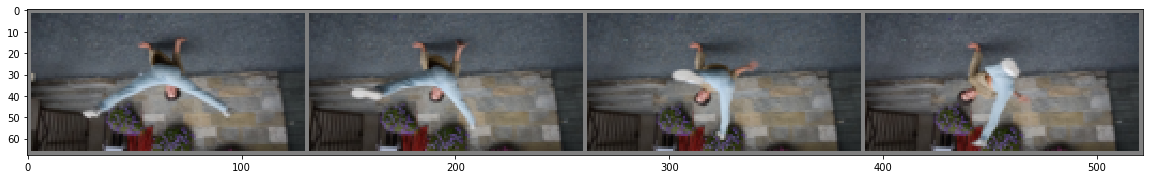

In [6]:
y_train, dpt = dataiter.next()
y_train = y_train.cuda()
dpt = dpt.cuda()

# show images
imshow(torchvision.utils.make_grid(y_train[0]).cpu())

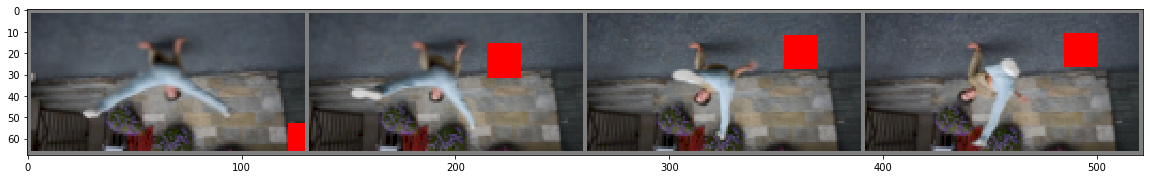

tensor([[ 0.6143,  0.8864],
        [-0.5478,  0.3080],
        [-0.6842,  0.4418],
        [-0.7010,  0.4633]], device='cuda:0')


In [7]:
J_est = []
I_est = []
loc = []

l = torch.rand(1, 2, device="cuda:0")*2-1
I = getDefocuesImage(l, y_train[:, 0, ...], dpt[:, 0, ...])
J_prev = I

I_est.append(I)
J_est.append(J_prev)
loc.append(l)

with torch.no_grad():
    model.init_hidden()
    for t in range(y_train.size()[1]-1):
        mu, l, b, p = model(I, l)
        I = getDefocuesImage(l, y_train[:, t+1, ...], dpt[:, t+1, ...])
        J_prev = fuseTwoImages(I, J_prev)
        J_est.append(J_prev)
        I_est.append(I)
        loc.append(mu)
        
    J_est = torch.stack(J_est, dim = 1)
    I_est = torch.stack(I_est, dim = 1)
    loc = torch.stack(loc, dim = 1)

imshow(torchvision.utils.make_grid(color_region(I_est[0], loc[0])).cpu())
print(loc[0])

# REAL IMAGES TEST

tensor([[0.4791, 0.9206]], device='cuda:0')


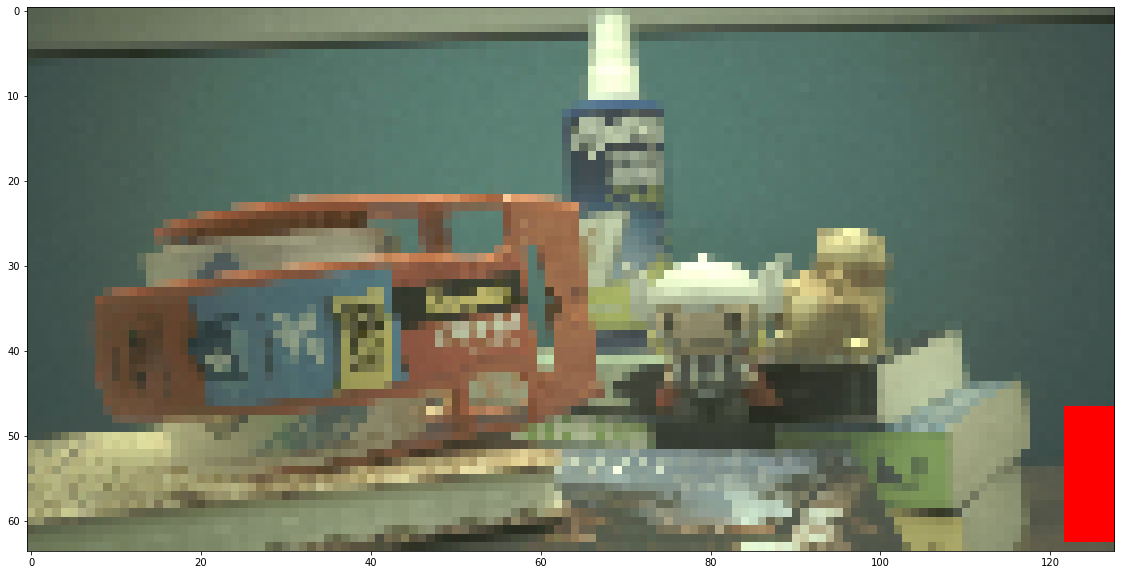

tensor([[-0.5047,  0.2708]], device='cuda:0')


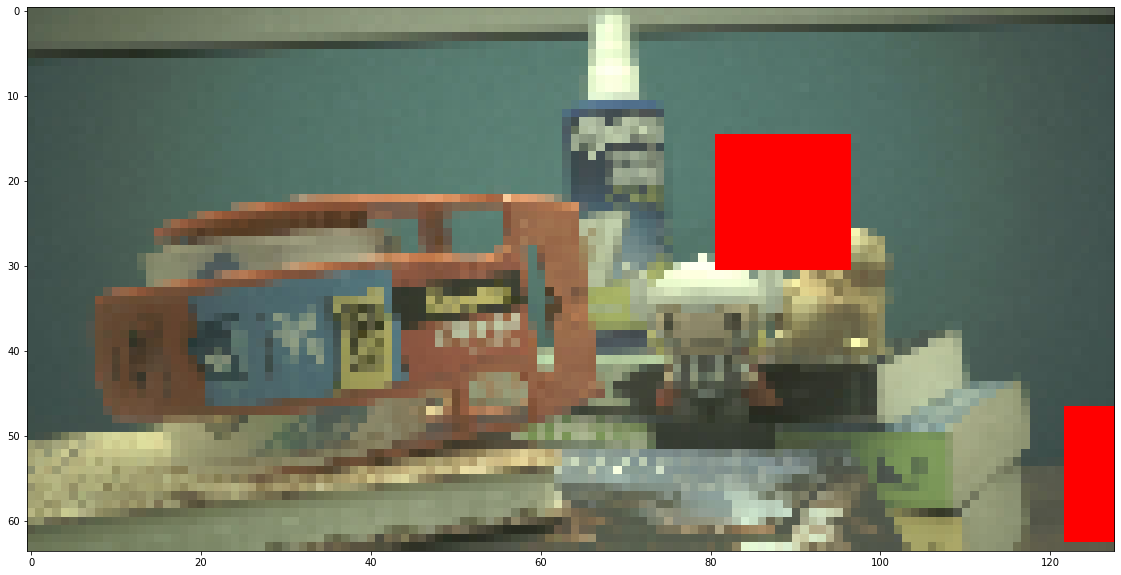

In [8]:
import cv2

l = torch.rand(1, 2, device="cuda:0").float()
print(l)
I = cv2.imread('/home/qian/Documents/pyFusion/test_files/68302_s550_00.jpg')
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
I = cv2.resize(I, (128, 64))
I = I.transpose(2, 0, 1)
I = torch.tensor(I/127.5 - 1, device="cuda:0").float().unsqueeze(0)
imshow(torchvision.utils.make_grid(color_region(I, l)).cpu())

with torch.no_grad():
    model.init_hidden()
    mu, l, b, p = model(I, l)
print(mu)

imshow(torchvision.utils.make_grid(color_region(I, mu)).cpu())

# TEST SNR

In [9]:
video_dataset = load_davis_dataset(video_path, depth_path, 4, 4)

<IPython.core.display.Javascript object>


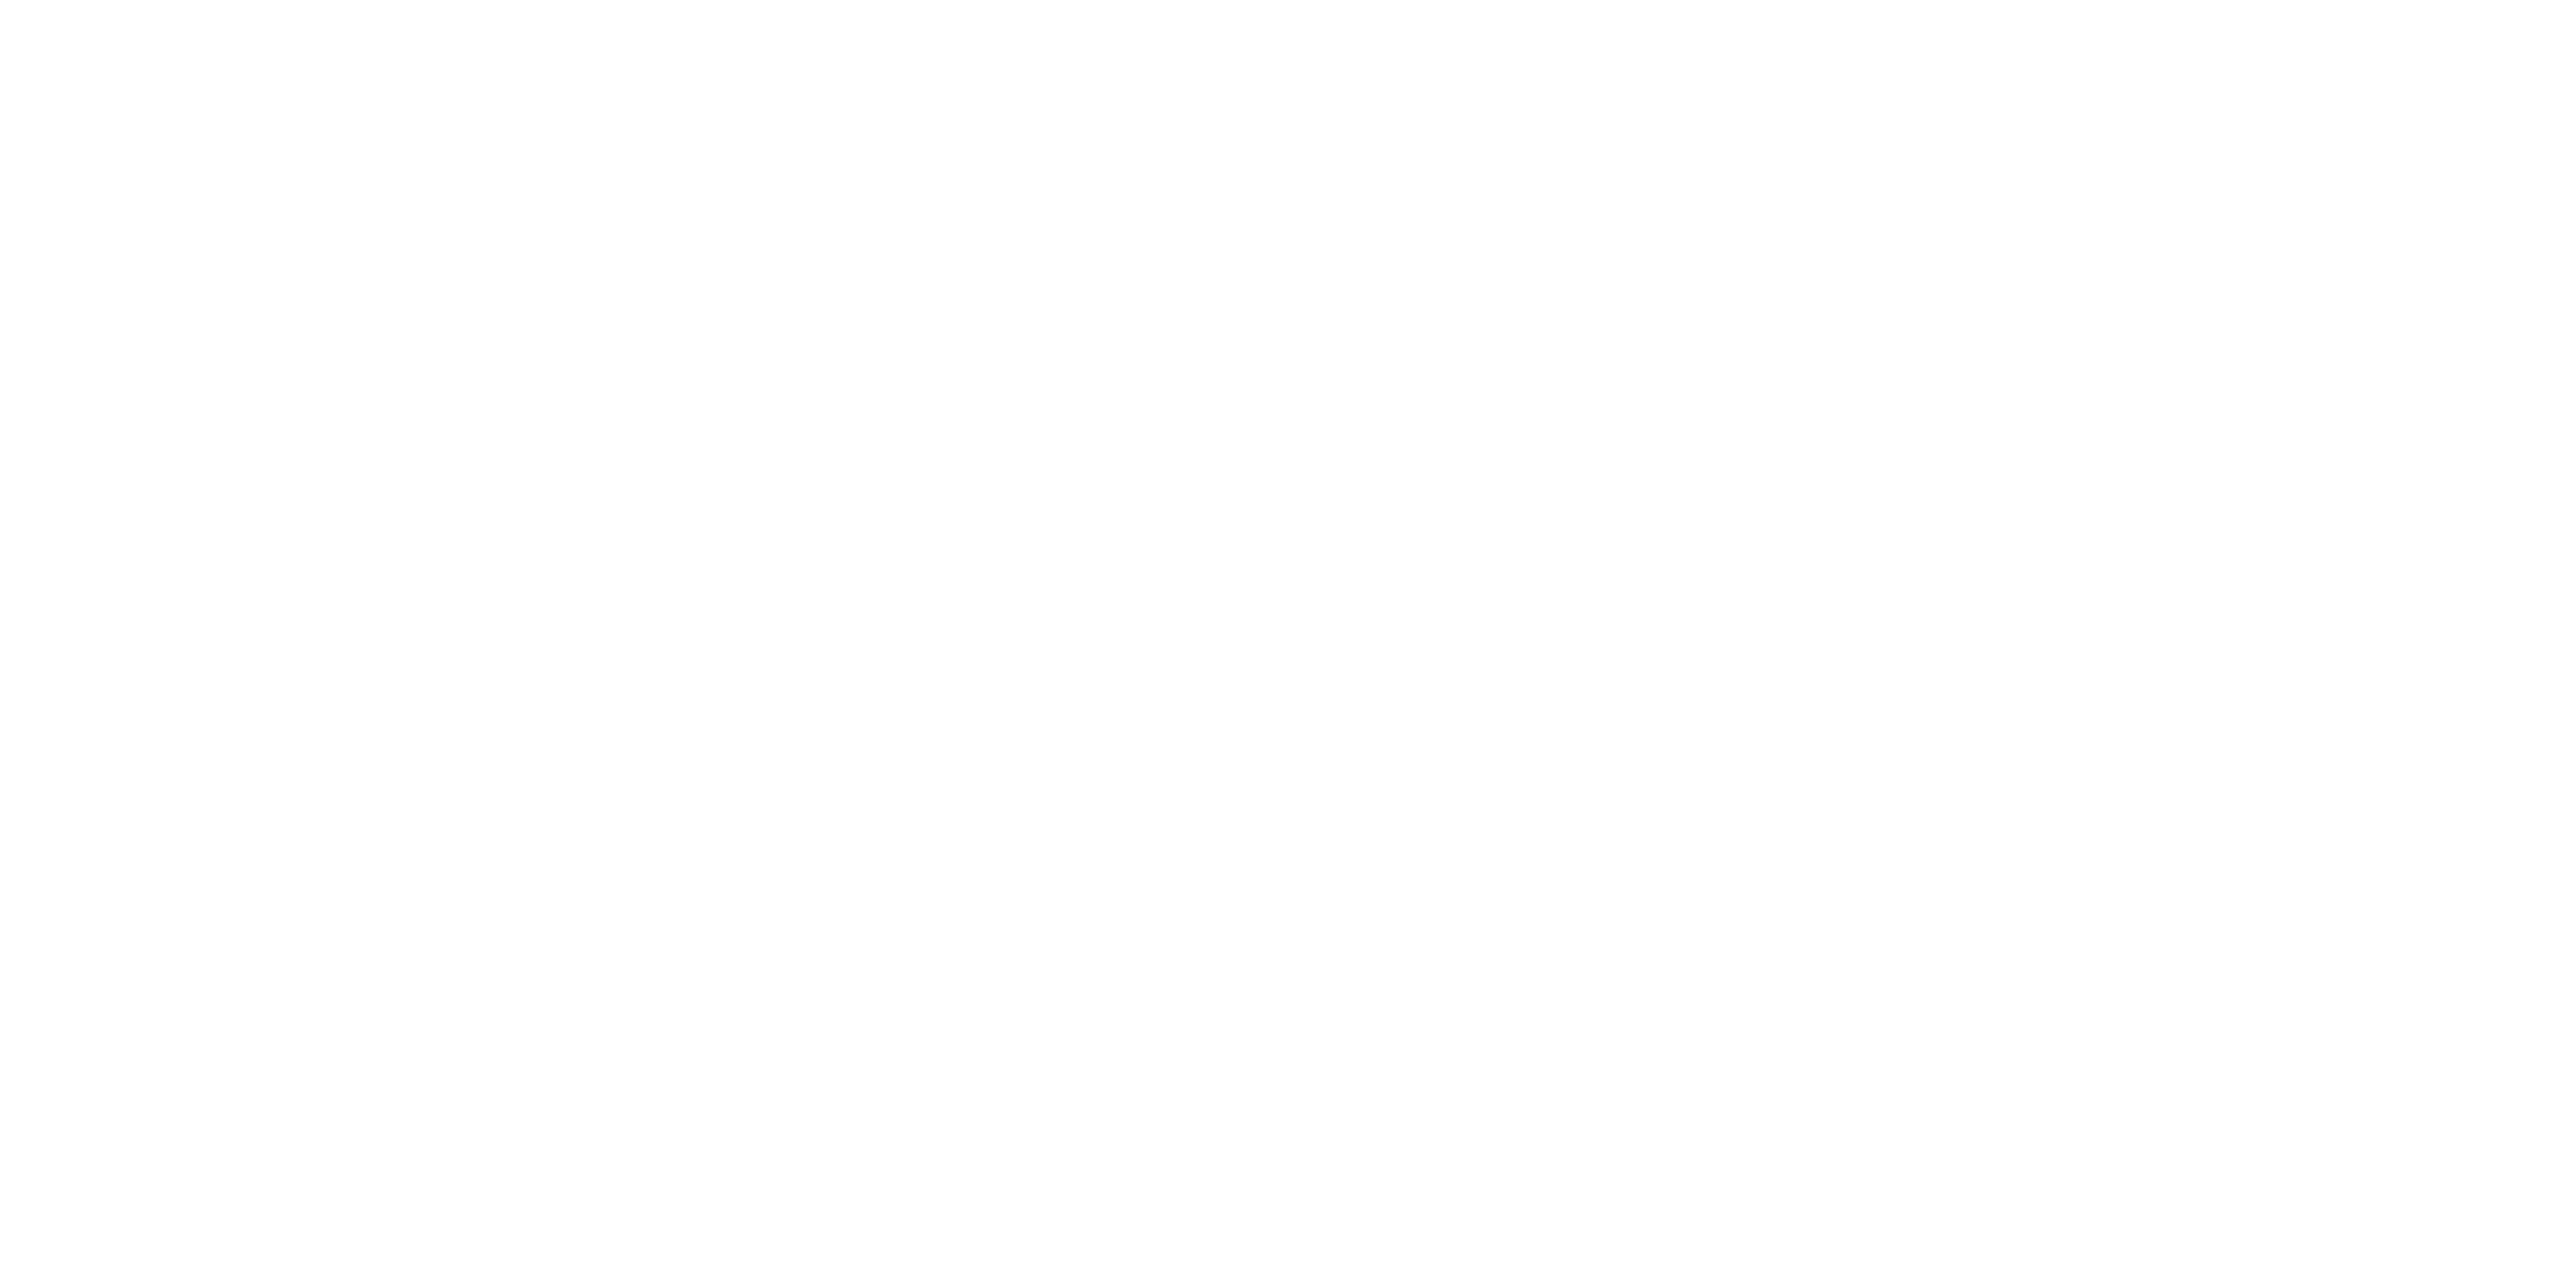

epoch: 0
999


<IPython.core.display.Javascript object>


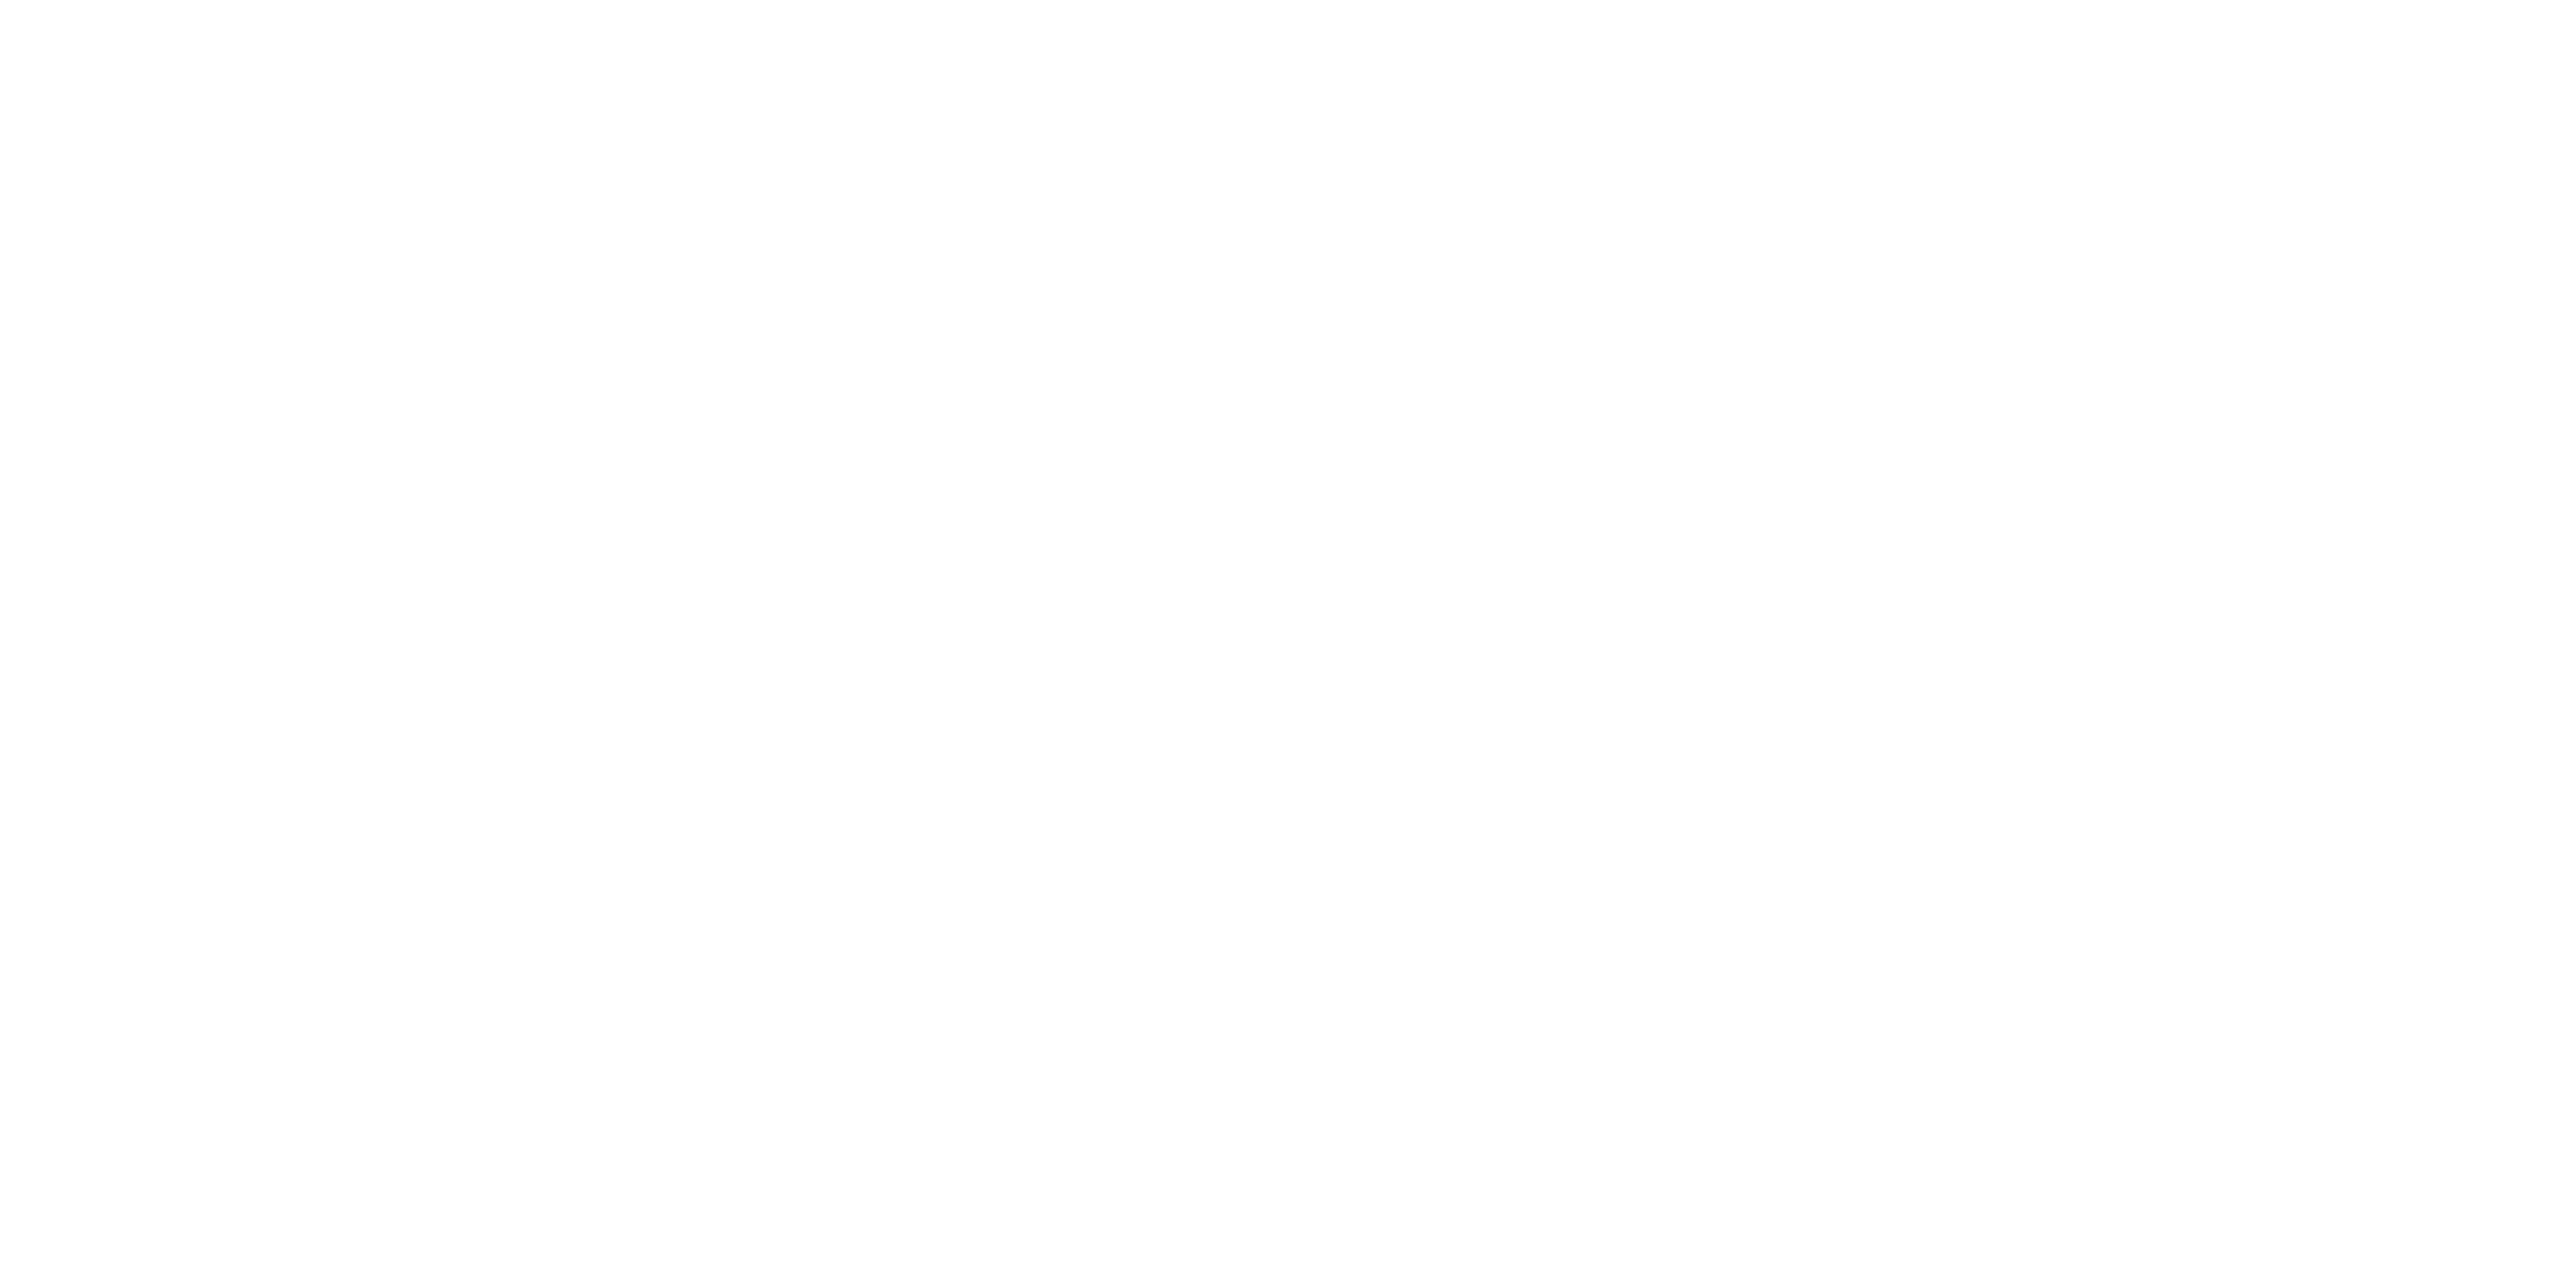

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook

class AverageMeter(object):
    """
    Computes and stores the average and
    current value.
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

losses_baseline = AverageMeter()
losses = AverageMeter()
Rs_i = AverageMeter()
Rs_central = AverageMeter()


y2= []
y1 = []
y0 = []

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)
plt.ion()
fig.show()
fig.canvas.draw()

for epoch in range(1):
    print("epoch:", epoch)
    for i, (y_train, dpt) in enumerate(video_dataset):
        if i % 1000 == 1000-1:
            print(i)

        y_train = y_train.cuda()
        dpt = dpt.cuda()

        J_est = []
        I_est = []
        I_central = []
        J_central = []
        loc = []

        l = torch.rand(4, 2, device="cuda:0")*2-1
        I = getDefocuesImage(l, y_train[:, 0, ...], dpt[:, 0, ...])
        J_prev = I
        I_c = I
        J_c = I

        I_est.append(I)
        J_est.append(J_prev)
        I_central.append(I_c)
        J_central.append(J_c)
        
        loc.append(l)
        model.init_hidden()

        with torch.no_grad():
            for t in range(y_train.size()[1]-1):
                mu, l, b, p = model(I, l)
                l_c = torch.zeros(4, 2, device="cuda:0")
                I = getDefocuesImage(l, y_train[:, t+1, ...], dpt[:, t+1, ...])
                I_c = getDefocuesImage(l_c, y_train[:, t+1, ...], dpt[:, t+1, ...])
                J_prev = fuseTwoImages(I, J_prev)
                J_c = fuseTwoImages(I_c, J_c)
                J_est.append(J_prev)
                I_est.append(I)
                I_central.append(I_c)
                J_central.append(J_c)
                loc.append(l)
            
            J_est = torch.stack(J_est, dim = 1)
            I_est = torch.stack(I_est, dim = 1)
            J_central = torch.stack(J_central, dim = 1)
            I_central = torch.stack(I_central, dim = 1)
            loc = torch.stack(loc, dim = 1)
            
            R_i = -reconsLoss(J_est[:, 1:], y_train[:, 1:])
            R_i = torch.mean(R_i, dim = 0)
            Rs_i.update(R_i.item(),y_train.size()[0])
            R_central = -reconsLoss(J_central[:, 1:], y_train[:, 1:])
            R_central = torch.mean(R_central, dim = 0)
            Rs_central.update(R_central.item(),y_train.size()[0])
            
            iteration = epoch*len(video_dataset) + i
            
            y1.append(Rs_i.avg)
            y2.append(Rs_central.avg)
            y0.append(iteration)
            
            if i % 10 == 9:
                ax.clear()
                ax.plot(y0, y1)
                ax.plot(y0, y2, '--')
                #plt.pause(0.1)
                fig.canvas.draw()
#             losses_baseline.update(torch.mean((I_est[:, 1:] - y_train[:, 1:])**2))
#             losses.update(torch.mean((J_est[:, 1:] - y_train[:, 1:])**2))

#     y1.append(losses_baseline.avg.item())
#     y2.append(losses.avg.item())
# plt.boxplot([y1, y2])

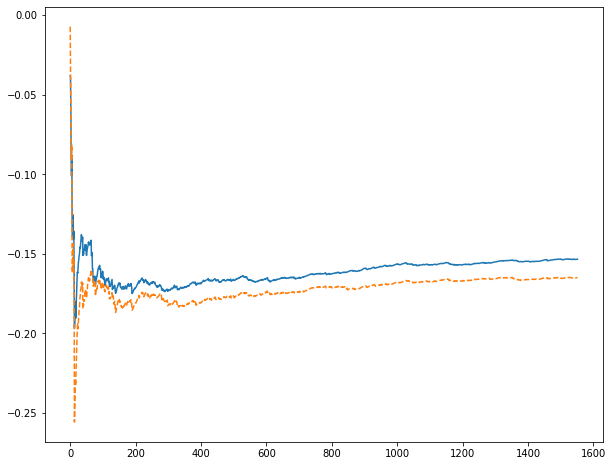

In [17]:
%matplotlib inline
fig = plt.figure(figsize = (10, 8))
plt.plot(y0, y1)
plt.plot(y0, y2, '--')
plt.show()

In [18]:
y1[-1]

-0.15333786822787063

In [19]:
y2[-1]

-0.1648988779107668